In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from keras import backend as K
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense, Dropout, regularizers
from keras.layers import LSTM, GRU
from keras.callbacks import EarlyStopping
from keras import optimizers


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_length = 24000
stock = '11869'
gdf_filename_pattern = 'gdf_{}_r{}_s{}_K50'
gdf_parameters = [(0.1, 0.1), (0.01, 0.1), (0.1, 0.5), (0.01, 0.5), (0.25, 0.25)]

In [3]:
df_log = pd.read_csv('../../gdf_pca/res_log_que.csv')   
df_log = df_log[df_log['stock'] == int(stock)]
columns = [c for c in df_log.columns if 'matthews' in c or 'roc_auc' in c]
df_log[columns]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
31,0.120455,0.566097,0.105285,0.557722,0.11906,0.567023,0.116874,0.565572


In [4]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, data_dir='../../data/data_gdf',
        reg_data_dir='../../data/prepared',
        gdf_filename_pattern=gdf_filename_pattern))

In [5]:
df = gdf_dfs[4].df
df_test = gdf_dfs[4].df_test
n_components = gdf_dfs[4].get_pca('pca_n_gdf_que_prev').n_components_
class_weights = gdf_dfs[4].get_classes_weights()
print(n_components, class_weights)

8 {0.0: 0.6839199202051867, 1.0: 1.8592872361030408}


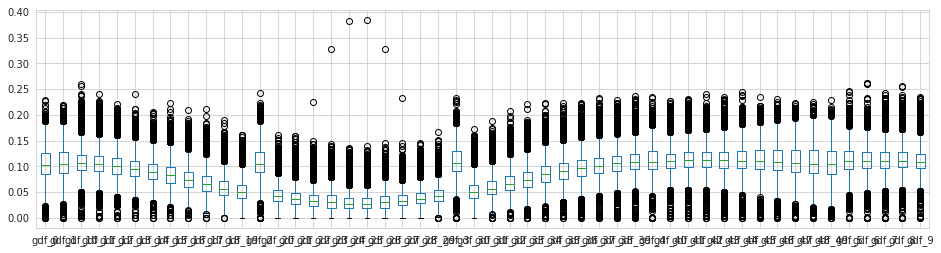

In [6]:
df[[c for c in df.columns if 'gdf' in c]].boxplot(figsize=(16, 4))

In [7]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
import tensorflow as tf
auc_roc = as_keras_metric(tf.metrics.auc)

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [8]:
## With validation

In [9]:
n_steps = 8
gdf_df = gdf_dfs[2]
feature = 'pca_n_gdf_que'
n_comp = gdf_df.get_pca(feature).n_components
print(n_steps, n_comp)

8 6


In [10]:
n_steps = 8
gdf_df = gdf_dfs[2]

def get_model1():
    model = Sequential()
    model.add(GRU(32, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(16, kernel_regularizer=regularizers.l1(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model
0.13876168114889534 0.5782319261400299
0.1271415312702948 0.5677567257778151
0.1023962732926067 0.5555092877190566

SyntaxError: invalid syntax (<ipython-input-10-caed30d124eb>, line 13)

In [28]:
n_steps = 8
gdf_df = gdf_dfs[2]

def get_model():
    model = Sequential()
    model.add(GRU(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(GRU(16, kernel_regularizer=regularizers.l1(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model
0.14195273661062094 0.5797111033031918
0.12879977295139053 0.5693508110416742
0.0914964392486798 0.5490069916156728

In [31]:

n_steps = 8
gdf_df = gdf_dfs[2]
def get_model():
    model = Sequential()
    model.add(GRU(32, return_sequences=False, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model
0.14384091074923505 0.5809873113945533
0.12936630427096044 0.5708005138297803
0.08817875600848211 0.547856601732982

In [34]:
n_steps = 8
gdf_df = gdf_dfs[2]

def get_model():
    model = Sequential()
    model.add(GRU(16, return_sequences=False, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model
0.13946658648467944 0.5785542790344108
0.12688916043079282 0.5681297841688278
0.0929357242625515 0.5506433000630035

In [38]:
n_steps = 8
gdf_df = gdf_dfs[2]

def get_model():
    model = Sequential()
    model.add(GRU(8, return_sequences=False, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model
0.13364822355837433 0.5752189900382736
0.1234326956583218 0.5667214998318145
0.1031328761694324 0.5564660328894172

In [42]:
n_steps = 8
gdf_df = gdf_dfs[2]

def get_model():
    model = Sequential()
    model.add(GRU(12, return_sequences=False, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model
0.13594598927335233 0.5765832029558131
0.13119383011144406 0.5705891789457638
0.09797712254237761 0.5531092411252905

In [50]:
n_steps = 8
gdf_df = gdf_dfs[2]

def get_model():
    model = Sequential()
    model.add(GRU(8, return_sequences=False, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model
0.14577251605638655 0.5819943120044548
0.12537511396211412 0.567607971539028
0.09067364441418228 0.5491747036661981

In [52]:
n_steps = 8
gdf_df = gdf_dfs[2]

def get_model():
    model = Sequential()
    model.add(GRU(12, return_sequences=False, kernel_regularizer=regularizers.l1(0.00001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model
0.1483109059315552 0.583208756507827
0.12215469057863655 0.5649851415039888
0.09082398016698766 0.5493079805428515

In [13]:
n_steps = 32
gdf_df = gdf_dfs[2]

def get_model():
    model = Sequential()
    model.add(GRU(8, return_sequences=False, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model

0.13890627541491596 0.5777022533342522
0.1223750552326098 0.5653023020234909
0.09890510611135374 0.5531347336131602

In [16]:
n_steps = 8
gdf_df = gdf_dfs[0]

def get_model():
    model = Sequential()
    model.add(GRU(8, return_sequences=False, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model

0.13292650769567657 0.5748395693564212
0.11831111210372991 0.5625453960511329
0.10606339695782896 0.5578368503974499

In [19]:
n_steps = 8
gdf_df = gdf_dfs[0]

def get_model():
    model = Sequential()
    model.add(GRU(8, return_sequences=False, kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model

0.12702988467881737 0.5714642831888131
0.12411027463542668 0.5658685548585016
0.0972924793824449 0.5533205285501601

In [22]:
n_steps = 12
gdf_df = gdf_dfs[0]

def get_model():
    model = Sequential()
    model.add(GRU(8, return_sequences=False, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model
print(score['train_matthews'], score['train_roc_auc'])
print(score['matthews'], score['roc_auc'])
print(score['test_matthews'], score['test_roc_auc'])

In [25]:
n_steps = 12
gdf_df = gdf_dfs[0]

def get_model():
    model = Sequential()
    model.add(GRU(8, return_sequences=False, kernel_regularizer=regularizers.l2(0.00001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.0001)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, matthews_correlation])
    return model

In [26]:
epochs = 50
batch_size = 256
score, m = gdf_df.train_lstm(
    get_model, feature_name=feature, plot_name=f'here_{stock}.png', n_steps=n_steps, 
    fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 1, 'shuffle': False}, 
    class_weight=class_weights, should_return_model=True,
    compile_kwargs= { 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': [auc_roc, matthews_correlation]})
print(score['train_matthews'], score['train_roc_auc'])
print(score['matthews'], score['roc_auc'])
print(score['test_matthews'], score['test_roc_auc'])

Train on 8720 samples, validate on 3488 samples
Epoch 1/50
8720/8720 [==============================] - 8s 932us/step - loss: 0.6813 - auc: 0.5256 - matthews_correlation: 0.0503 - val_loss: 0.6871 - val_auc: 0.5492 - val_matthews_correlation: 0.0765
Epoch 2/50
8720/8720 [==============================] - 1s 114us/step - loss: 0.6804 - auc: 0.5510 - matthews_correlation: 0.0676 - val_loss: 0.6822 - val_auc: 0.5528 - val_matthews_correlation: 0.0739
Epoch 3/50
8720/8720 [==============================] - 1s 85us/step - loss: 0.6788 - auc: 0.5554 - matthews_correlation: 0.0903 - val_loss: 0.6786 - val_auc: 0.5576 - val_matthews_correlation: 0.0823
Epoch 4/50
8720/8720 [==============================] - 1s 109us/step - loss: 0.6779 - auc: 0.5594 - matthews_correlation: 0.0980 - val_loss: 0.6772 - val_auc: 0.5611 - val_matthews_correlation: 0.0871
Epoch 5/50
8720/8720 [==============================] - 1s 73us/step - loss: 0.6764 - auc: 0.5620 - matthews_correlation: 0.1025 - val_loss: 0.67

8720/8720 [==============================] - 1s 90us/step - loss: 0.6713 - auc: 0.5858 - matthews_correlation: 0.1239 - val_loss: 0.6656 - val_auc: 0.5858 - val_matthews_correlation: 0.1603
Epoch 00024: early stopping
Train on 8720 samples, validate on 3488 samples
Epoch 1/50
8720/8720 [==============================] - 8s 865us/step - loss: 0.6945 - auc: 0.4737 - matthews_correlation: -0.0050 - val_loss: 0.6854 - val_auc: 0.4888 - val_matthews_correlation: 0.0178
Epoch 2/50
8720/8720 [==============================] - 1s 86us/step - loss: 0.6916 - auc: 0.4936 - matthews_correlation: -0.0064 - val_loss: 0.6875 - val_auc: 0.5012 - val_matthews_correlation: 0.1196
Epoch 3/50
8720/8720 [==============================] - 1s 75us/step - loss: 0.6890 - auc: 0.5053 - matthews_correlation: 0.0190 - val_loss: 0.6869 - val_auc: 0.5130 - val_matthews_correlation: 0.1173
Epoch 4/50
8720/8720 [==============================] - 1s 78us/step - loss: 0.6868 - auc: 0.5173 - matthews_correlation: 0.0363

Epoch 21/50
19188/19188 [==============================] - 1s 46us/step - loss: 0.6802 - auc: 0.5812 - matthews_correlation: 0.1259 - val_loss: 0.6926 - val_auc: 0.5815 - val_matthews_correlation: 0.1240
Epoch 22/50
19188/19188 [==============================] - 1s 44us/step - loss: 0.6794 - auc: 0.5819 - matthews_correlation: 0.1266 - val_loss: 0.6948 - val_auc: 0.5822 - val_matthews_correlation: 0.1204
Epoch 23/50
19188/19188 [==============================] - 1s 34us/step - loss: 0.6801 - auc: 0.5826 - matthews_correlation: 0.1257 - val_loss: 0.6939 - val_auc: 0.5828 - val_matthews_correlation: 0.1250
Epoch 24/50
19188/19188 [==============================] - 1s 36us/step - loss: 0.6802 - auc: 0.5831 - matthews_correlation: 0.1285 - val_loss: 0.6949 - val_auc: 0.5833 - val_matthews_correlation: 0.1224
Epoch 25/50
19188/19188 [==============================] - 1s 36us/step - loss: 0.6795 - auc: 0.5837 - matthews_correlation: 0.1292 - val_loss: 0.6928 - val_auc: 0.5839 - val_matthews_

19188/19188 [==============================] - 1s 56us/step - loss: 0.6809 - auc: 0.5773 - matthews_correlation: 0.1297
Epoch 17/50
19188/19188 [==============================] - 1s 59us/step - loss: 0.6802 - auc: 0.5785 - matthews_correlation: 0.1273
Epoch 18/50
19188/19188 [==============================] - 1s 61us/step - loss: 0.6806 - auc: 0.5795 - matthews_correlation: 0.1233
Epoch 19/50
19188/19188 [==============================] - 1s 44us/step - loss: 0.6797 - auc: 0.5803 - matthews_correlation: 0.1260
Epoch 20/50
19188/19188 [==============================] - 1s 53us/step - loss: 0.6786 - auc: 0.5813 - matthews_correlation: 0.1283
Epoch 21/50
19188/19188 [==============================] - 1s 43us/step - loss: 0.6808 - auc: 0.5821 - matthews_correlation: 0.1246
Epoch 22/50
19188/19188 [==============================] - 1s 43us/step - loss: 0.6798 - auc: 0.5827 - matthews_correlation: 0.1210
Epoch 23/50
19188/19188 [==============================] - 1s 43us/step - loss: 0.6802 -

In [27]:
print(score['train_matthews'], score['train_roc_auc'])
print(score['matthews'], score['roc_auc'])
print(score['test_matthews'], score['test_roc_auc'])

0.13684877127139608 0.5768978653987706
0.11977573955832346 0.5637747819301816
0.1054355341798709 0.5567608065409296


### val 0.129617 log 0.105285

In [12]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 4,161
Trainable params: 4,161
Non-trainable params: 0
_________________________________________________________________
